# Node-level membership inference attack (MIA) adapted for graph level predictions
## Keenan Hom
The original choice for MIA is here: https://arxiv.org/pdf/2102.05429. This notebook adapts it to be used for graph level predictions, suitable for our needs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import sys
# # Add the project root (the folder containing "main") to sys.path
# sys.path.append('..')
# from membership_inference_attack.ml_util import train_model

In [4]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from ml_util import (
    CustomGATModel, GenericAttackModel, train_model_multi_graph, train_model, 
    load_model, get_accuracy, get_auroc_score, predict, predict_multi_graph
)
from util import create_attack_dataset, graph_train_test_split, onehot_transform
from train_models import get_dataset, shadow_target_split

In [5]:
dataset_name = 'ogbg-molhiv'

In [7]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
dataset = get_dataset(dataset_name)
num_feat = dataset[0].x.shape[1]
num_categories = dataset[0].y.shape[1]

In [9]:
t_dataset_train, t_dataset_test, s_dataset_train, s_dataset_test = shadow_target_split(dataset)

In [10]:
# lr = 0.001
# epochs = 100
# batch_size = 8
# weight_decay = 1e-4
t_model = CustomGATModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)
# optimizer = optim.Adam(t_model.parameters(), lr=lr)
# t_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
#                                                        factor=0.5,
#                                                        patience=50,
#                                                        min_lr=1e-6,
#                                                        verbose=True)

# weight = compute_class_weight('balanced', classes=np.unique(t_dataset_train.y.argmax(dim=1)), y=t_dataset_train.y.argmax(dim=1).numpy())
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
t_save_path = 'mia-models/t_model_gat_ogbg-molhiv.pth'
# t_save_path = None

# train_model_multi_graph(t_model, optimizer, t_dataset_train, loss_fn, epochs, batch_size, val_dataset=t_dataset_test, 
#                         save_path=t_save_path, save_freq=10, scheduler=t_scheduler, device=DEVICE)
t_model, t_dataset_train, t_dataset_test = load_model(t_model, t_save_path)
t_model.eval()

CustomGATModel(
  (embedding): Linear(in_features=9, out_features=144, bias=True)
  (gat_layers): ModuleList(
    (0-2): 3 x GATConv(144, 18, heads=8)
    (3): GATConv(144, 144, heads=1)
  )
  (bns): ModuleList(
    (0-3): 4 x BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): MLP(144, 72, 36, 2)
)

In [11]:
# Create and train shadow model
# lr = 0.001
# epochs = 100
# batch_size = 8
# weight_decay = 1e-4
s_model = CustomGATModel(num_feat=num_feat, num_classes=num_categories).to(DEVICE)
# optimizer = optim.Adam(s_model.parameters(), lr=lr, weight_decay=weight_decay)
# s_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
#                                                        factor=0.5,
#                                                        patience=50,
#                                                        min_lr=1e-6,
#                                                        verbose=True)
# weight = compute_class_weight('balanced', classes=np.unique(s_dataset_train.y.argmax(dim=1)), y=s_dataset_train.y.argmax(dim=1).numpy())
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
s_save_path = 'mia-models/s_model_gat_ogbg-molhiv.pth'
# s_save_path = None

# train_model_multi_graph(s_model, optimizer, s_dataset_train, loss_fn, epochs, batch_size, val_dataset=s_dataset_test, save_path=s_save_path, save_freq=10, device=DEVICE)
s_model, s_dataset_train, s_dataset_test = load_model(s_model, s_save_path)
s_model.eval()

CustomGATModel(
  (embedding): Linear(in_features=9, out_features=144, bias=True)
  (gat_layers): ModuleList(
    (0-2): 3 x GATConv(144, 18, heads=8)
    (3): GATConv(144, 144, heads=1)
  )
  (bns): ModuleList(
    (0-3): 4 x BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): MLP(144, 72, 36, 2)
)

In [12]:
logits = predict_multi_graph(s_model, s_dataset_train, device=DEVICE, logits=True, return_type='pt')
targets = torch.cat([g.y for g in s_dataset_train])
# get_accuracy(logits, targets)
get_auroc_score(logits, targets, multiclass=(num_categories>2))

0.9860140323609299

In [13]:
logits = predict_multi_graph(s_model, s_dataset_test, device=DEVICE, logits=True, return_type='pt')
targets = torch.cat([g.y for g in s_dataset_test])
# get_accuracy(logits, targets)
get_auroc_score(logits, targets, multiclass=(num_categories>2))

0.7676190295615655

In [14]:
att_dataset_train = create_attack_dataset(s_model, s_dataset_train, s_dataset_test, device=DEVICE)
att_dataset_test = create_attack_dataset(t_model, t_dataset_train, t_dataset_test, device=DEVICE)

lr = 0.001
epochs = 50
batch_size = 16
weight_decay = 1e-3
att_model = GenericAttackModel(num_feat=num_categories).to(DEVICE)
optimizer = optim.Adam(att_model.parameters(), lr=lr, weight_decay=weight_decay)
weight = compute_class_weight('balanced', 
                              classes=np.unique(att_dataset_train.tensors[1].argmax(dim=1)), 
                              y=att_dataset_train.tensors[1].argmax(dim=1).numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(DEVICE))
# loss_fn = nn.CrossEntropyLoss()

train_model(att_model, optimizer, att_dataset_train, loss_fn, epochs, batch_size, val_dataset=att_dataset_test, device=DEVICE)
att_model.eval()

Learning rate: 0.001
No learning rate scheduling!
Training for 50 epochs, with batch size=16
Using device: cuda:0

-----Epoch 1/50-----
Batch 50/1286 | loss: 0.6844947509783652 (0.124s) | train acc: 0.5363 | train auc: 0.547243
Batch 100/1286 | loss: 0.688839272769275 (0.063s) | train acc: 0.5600 | train auc: 0.548061
Batch 150/1286 | loss: 0.6939873649318651 (0.064s) | train acc: 0.5429 | train auc: 0.532302
Batch 200/1286 | loss: 0.7099263077524466 (0.064s) | train acc: 0.5297 | train auc: 0.526566
Batch 250/1286 | loss: 0.7034724149711938 (0.064s) | train acc: 0.5078 | train auc: 0.519976
Batch 300/1286 | loss: 0.6995981910919029 (0.064s) | train acc: 0.4967 | train auc: 0.513419
Batch 350/1286 | loss: 0.6980951836745811 (0.064s) | train acc: 0.4984 | train auc: 0.511492
Batch 400/1286 | loss: 0.6888716328825586 (0.064s) | train acc: 0.5030 | train auc: 0.512050
Batch 450/1286 | loss: 0.6966380457550782 (0.063s) | train acc: 0.5054 | train auc: 0.512636
Batch 500/1286 | loss: 0.6966

KeyboardInterrupt: 

In [15]:
pred_scores_test = predict(att_model, att_dataset_test, device=DEVICE, logits=True, return_type='pt').cpu()
true_scores_test = att_dataset_test.tensors[1]
get_auroc_score(pred_scores_test, true_scores_test)

0.5027751177567983

In [41]:
pred_scores_train = predict(att_model, att_dataset_train, device=DEVICE, logits=True, return_type='pt').cpu()
true_scores_train = att_dataset_train.tensors[1]
get_auroc_score(pred_scores_train, true_scores_train)

0.7142866732901909

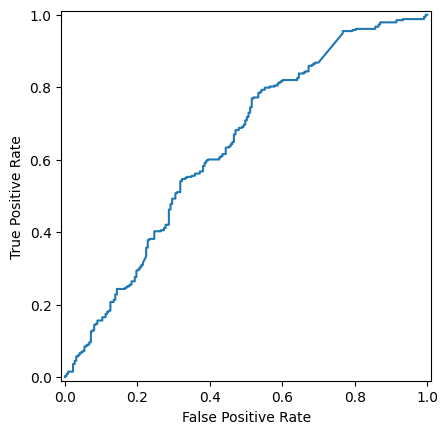

In [42]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(true_scores_test.argmax(dim=1), pred_scores_test[:,1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()